In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Table of Contents

* [Libraries](#Libraries)
* [Data](#Data)
    * [Field Description](#Field-Description)
    * [Data Properties](#Data-Properties)
* [Exploratory Data Anaysis](#Exploratory-Data-Anaysis)
    * [Descriptive Analysis](#Descriptive-Analysis)
    * [Univariate Analysis](#Univariate-Analysis)
    * [Bivariate Analysis](#Bivariate-Analysis)
* [Preprocessing](#Preprocessing)
    * [Related Values](#Related-Values)
    * [Encoding](#Encoding)
    * [Standard Scaler](#Standard-Scaler)
    * [PCA Dimensionality Reduction](#PCADimensionality-Reduction)
    * [Split Dataset](#Split-Dataset)
    * [Remove Outliers](#Remove-Outliers)
    * [Fix Class Imbalance](#Fix-Class-Imbalance)
* [Machine Learning Models](#Machine-Learning-Models)
    * [Experiment](#Experiment)

## Libraries

In [39]:
# linear algebra and data processing
import numpy as np
import pandas as pd 

#data visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

# models + accuracy metrics
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn import model_selection
from sklearn.utils import class_weight

# saving models
import pickle
import gzip

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

## Data

#### Field Description


- age (numeric)
- job : type of job (categorical:
'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-emplo
yed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note:
'divorced' means divorced or widowed)
- education (categorical):
'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.
degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')

related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical:
'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric)

other attributes:
- campaign: number of contacts performed during this campaign and for this
client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted
from a previous campaign (numeric; 999 means client was not previously
contacted)
- previous: number of contacts performed before this campaign and for this
client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical:
'failure','nonexistent','success')

social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)
Output variable (desired target):
- y - has the client subscribed to a term deposit? (binary: 'yes','no')


#### Data Properties

In [47]:
data = pd.read_csv(f'{root_path}/bank-institution-term-deposit/bank-additional-full.csv', sep=';')

print('data shape:', data.shape)
data.head()

data shape: (41188, 21)


age        job  marital  ... euribor3m nr.employed   y
0   56  housemaid  married  ...     4.857      5191.0  no
1   57   services  married  ...     4.857      5191.0  no
2   37   services  married  ...     4.857      5191.0  no
3   40     admin.  married  ...     4.857      5191.0  no
4   56   services  married  ...     4.857      5191.0  no

[5 rows x 21 columns]

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

>Luckily for us, there are no null values



## Exploratory Data Analysis

#### Descriptive analysis

In [49]:
data.describe().T

count         mean         std  ...       50%       75%       max
age             41188.0    40.024060   10.421250  ...    38.000    47.000    98.000
duration        41188.0   258.285010  259.279249  ...   180.000   319.000  4918.000
campaign        41188.0     2.567593    2.770014  ...     2.000     3.000    56.000
pdays           41188.0   962.475454  186.910907  ...   999.000   999.000   999.000
previous        41188.0     0.172963    0.494901  ...     0.000     0.000     7.000
emp.var.rate    41188.0     0.081886    1.570960  ...     1.100     1.400     1.400
cons.price.idx  41188.0    93.575664    0.578840  ...    93.749    93.994    94.767
cons.conf.idx   41188.0   -40.502600    4.628198  ...   -41.800   -36.400   -26.900
euribor3m       41188.0     3.621291    1.734447  ...     4.857     4.961     5.045
nr.employed     41188.0  5167.035911   72.251528  ...  5191.000  5228.100  5228.100

[10 rows x 8 columns]

#### Univariate Analysis

In [50]:
## Function for plotting univariate catplots
def catplot(x,data):
    plot= sns.catplot(x, kind="count", data=data, palette="Set1")
    plt.xticks(rotation=45, horizontalalignment='right' )
    plt.title("counts"+ " "+ "of" + " "+ " " + x )
    return 

**Target**

First thing to cross check is to know if the target class is balanced or not.

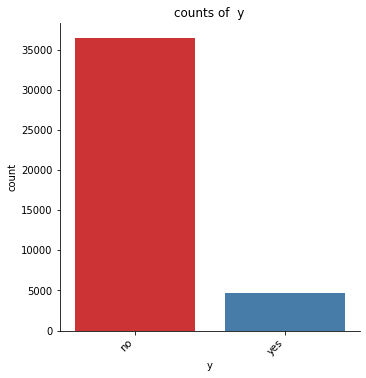

In [51]:
catplot("y",data=data)

There seems to be alot of more clients that have not subscribed to a term deposit.This is certainly a class imbalanced problem. 

1. This class imbalance problem could impact our model performance making the model biased and inaccurate. This is because Machine Learning Algorithms are usually designed to improve accuracy by reducing the error. Thus, they do not take into account the class distribution / proportion or balance of classes.

2. A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class.(over-sampling).

We will be using imblearn's **SMOTE** to over-sample the target




**Marital Status**

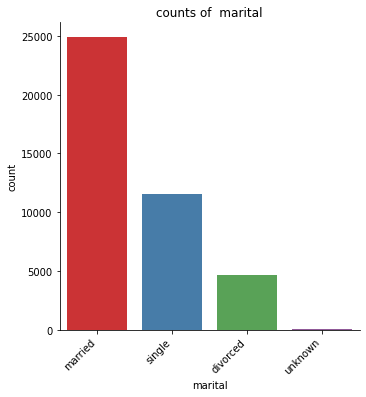

In [52]:
catplot("marital", data=data)

**Education**

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64


Text(0.5, 0, 'education')

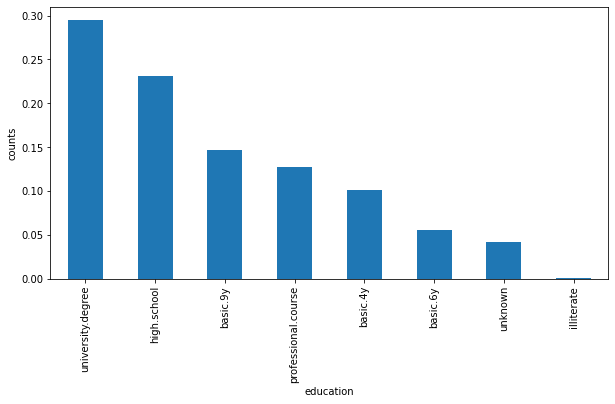

In [53]:
print(data['education'].value_counts())
plt.figure(figsize=(10,5))
data['education'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('education')

**Job**

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


Text(0.5, 0, 'job')

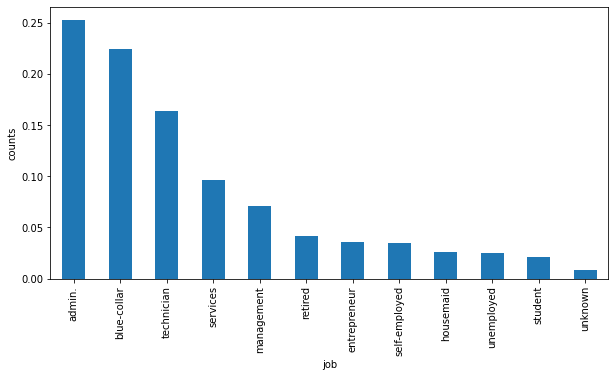

In [54]:
print(data['job'].value_counts())
plt.figure(figsize=(10,5))
data['job'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('job')

**Age Distribution**

Text(0.5, 1.0, 'Age Distribution')

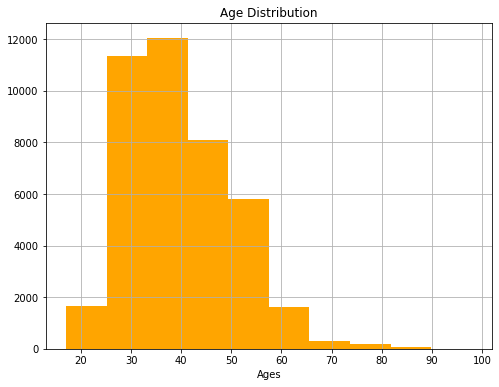

In [55]:
plt.figure(figsize=(8, 6))
data.age.hist( color="orange") 
plt.xlabel('Ages')
plt.title("Age Distribution")

#### Bivariate Analysis

In [56]:
## Funv=ction for plotting Bivariate Boxplots
def boxplot(x, y, data=data, hue= "y"):
    plot = sns.boxplot(x= x, y=y, hue=hue, data= data)
    plt.xticks( rotation=45, horizontalalignment='right' )
    plt.title("Boxplot of " + " " + x.upper() + " " + "and "+ " " + y.upper())
    return plot

**Marital vs. age and target**

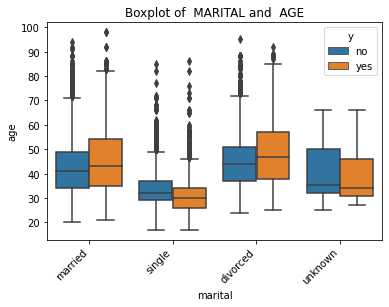

In [57]:
boxplot("marital", "age", data=data, hue= "y")

**Education vs. age and target**

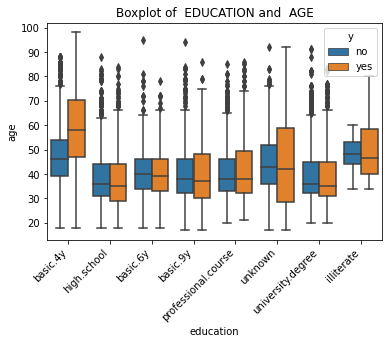

In [58]:
boxplot("education", "age", data=data, hue= "y")

**Correlation**

In [59]:
data.corr()

age  duration  ...  euribor3m  nr.employed
age             1.000000 -0.000866  ...   0.010767    -0.017725
duration       -0.000866  1.000000  ...  -0.032897    -0.044703
campaign        0.004594 -0.071699  ...   0.135133     0.144095
pdays          -0.034369 -0.047577  ...   0.296899     0.372605
previous        0.024365  0.020640  ...  -0.454494    -0.501333
emp.var.rate   -0.000371 -0.027968  ...   0.972245     0.906970
cons.price.idx  0.000857  0.005312  ...   0.688230     0.522034
cons.conf.idx   0.129372 -0.008173  ...   0.277686     0.100513
euribor3m       0.010767 -0.032897  ...   1.000000     0.945154
nr.employed    -0.017725 -0.044703  ...   0.945154     1.000000

[10 rows x 10 columns]

## Data Preprocessing

#### Related Values

In [60]:
data.education.value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [61]:
data["education"].replace({"basic.4y": "basic","basic.6y": "basic","basic.9y": "basic", "illiterate": "unknown"},
                        inplace=True)

In [62]:
data.education.value_counts()

basic                  12513
university.degree      12168
high.school             9515
professional.course     5243
unknown                 1749
Name: education, dtype: int64

#### Encoding

In [63]:
## Categorical boolean mask
cat_feature_mask = data.dtypes==object
## filter categorical columns using mask and turn it into a list
cat_cols = data.columns[cat_feature_mask].tolist()
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [64]:
## Function to collect label encoder columns and Dummy columns

label_cols = []
dummy_cols = []
def encoder_cols(cat_cols):
  for col in cat_cols:
    if data[col].nunique()==2:
      label_cols.append(col)
    else:
      dummy_cols.append(col)
  return label_cols, dummy_cols
    

In [65]:
encoder_cols(cat_cols)

(['contact', 'y'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'month',
  'day_of_week',
  'poutcome'])

In [66]:
## Lable Encoder
le = LabelEncoder()
data[label_cols] = data[label_cols].apply(lambda col: le.fit_transform(col))
data[label_cols].head(10)

contact  y
0        1  0
1        1  0
2        1  0
3        1  0
4        1  0
5        1  0
6        1  0
7        1  0
8        1  0
9        1  0

In [67]:
## Dummies
data = pd.get_dummies(data, columns = dummy_cols)
data.head()

age  contact  ...  poutcome_nonexistent  poutcome_success
0   56        1  ...                     1                 0
1   57        1  ...                     1                 0
2   37        1  ...                     1                 0
3   40        1  ...                     1                 0
4   56        1  ...                     1                 0

[5 rows x 60 columns]

#### Standard Scaler

In [68]:
## Numerical columns will be scaled
num_cols = ['emp.var.rate',"pdays","age", 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']

In [69]:
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

In [70]:
data.head()

age  contact  ...  poutcome_nonexistent  poutcome_success
0  1.533034        1  ...                     1                 0
1  1.628993        1  ...                     1                 0
2 -0.290186        1  ...                     1                 0
3 -0.002309        1  ...                     1                 0
4  1.533034        1  ...                     1                 0

[5 rows x 60 columns]

In [71]:
X = data.drop(columns=[ "y", 'duration'])
y = data["y"]
print(X.shape)
print(y.shape)

(41188, 58)
(41188,)


#### PCA Dimensionality Reduction

Text(0, 0.5, 'cumulative explained variance')

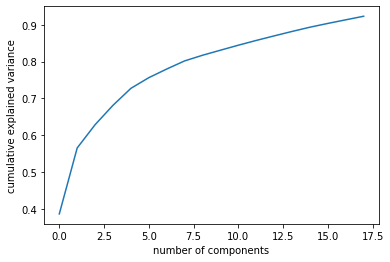

In [72]:
pca = PCA(n_components=18) #  18 components capture around 95% of the variance
pca_result = pca.fit_transform(X.values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [73]:
## New Features
new_X = pd.DataFrame(data=pca_result)
new_X

0         1         2   ...        15        16        17
0     -1.281406 -1.681349  1.454221  ... -0.585625 -0.728719 -0.198997
1     -1.264316 -1.754665  1.491749  ... -0.511838 -0.636701 -0.066944
2     -1.293511 -1.610155  0.311716  ... -0.545073 -0.703977 -0.167316
3     -1.283767 -1.657843  0.568246  ... -0.572469 -0.702370 -0.233661
4     -1.281400 -1.659568  1.351845  ... -0.489748 -0.729939 -0.144506
...         ...       ...       ...  ...       ...       ...       ...
41183 -1.859611  1.581750  0.666842  ...  0.096385  0.501287  0.203943
41184 -1.854315  1.534904 -0.842217  ...  0.029787  0.500766  0.165647
41185 -0.884327  1.805621 -0.236267  ...  0.072665  0.507905  0.160616
41186 -1.855102  1.545111 -0.918793  ...  0.013769  0.574210  0.212346
41187  0.042218  2.260660  0.909135  ...  0.083701  0.332388  0.141176

[41188 rows x 18 columns]

#### Split Dataset

In [74]:
X_train,X_test,y_train,y_test = train_test_split(new_X,y,test_size = 0.1,random_state=42)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(37069, 18)
(37069,)
(4119, 18)
(4119,)


#### Fix Class Imbalance

In [75]:
## Percentage of classes
y_train.value_counts()/len(y_train)

0    0.887291
1    0.112709
Name: y, dtype: float64

In [76]:
# cCreating an instance
sm = SMOTE(random_state=42)
# applying it to the training set
X_train, y_train = sm.fit_sample(X_train, y_train)

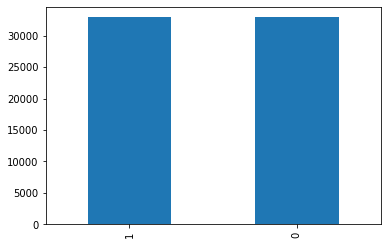

In [77]:
## Plotting target
pd.Series(y_train).value_counts().plot.bar()

>Now the target is balanced

#### Remove Outliers

In [80]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

(59203, 18) (59203,)


## Machine Learning Models

#### Experiment

In [81]:
## Funtion to test 5 models and find top 3
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
  
  models = [
            ('LogReg', LogisticRegression()),
            ('XGB', XGBClassifier()), 
            ('MLP', MLPClassifier()),
            ('SVM', SVC()), 
            ('RF', RandomForestClassifier())
            ]
            
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
  target_names = ["0", "1"]
  for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))
    save_zipped_pickle(clf, f'{root_path}/bank-institution-term-deposit/models/{name}.pkl')

# save the model
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol)

In [82]:
## Run Experiment
initial_ex = run_exps(X_train, y_train, X_test.to_numpy(), y_test.to_numpy())

LogReg
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      3657
           1       0.34      0.64      0.44       462

    accuracy                           0.82      4119
   macro avg       0.64      0.74      0.67      4119
weighted avg       0.88      0.82      0.84      4119

XGB
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3657
           1       0.36      0.62      0.46       462

    accuracy                           0.83      4119
   macro avg       0.65      0.74      0.68      4119
weighted avg       0.88      0.83      0.85      4119

MLP
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      3657
           1       0.31      0.51      0.39       462

    accuracy                           0.82      4119
   macro avg       0.62      0.68      0.64      4119
weighted avg       0.86      0.82      0.84      4119

SVM


[Back to top](#Table-of-Contents)